In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

def image_directory_to_pandas(image_path):
    """
    Create a pandas DataFrame with image paths and taxonomic labels extracted from a directory structure.

    Parameters:
    ----------
    image_path : str
        The root directory containing subfolders with images.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing image paths and label information. Columns include:
        - 'path': The full path to the image.
        - 'folder_label': The folder name, representing the original label (format: 'family_genus_species').
        - 'family': Extracted family name from the folder label.
        - 'genus': Extracted genus name from the folder label.
        - 'species': Combination of genus and species names (e.g., 'genus species').

    Raises:
    ------
    ValueError:
        If the folder label format does not match the expected 'family_genus_species' format.
    """
    labels = []
    paths = []

    # Walk through the directory and collect image paths and labels
    for root_dir, _, filenames in os.walk(image_path):
        for filename in filenames:
            # Ignore hidden files and non-image files
            if filename.startswith('.') or os.path.splitext(filename)[1].lower() not in {".jpeg", ".png", ".jpg"}:
                continue

            # Extract the folder name as the label, ignoring 'GT' directories
            folder_label = os.path.basename(root_dir)
            if folder_label != "GT":
                labels.append(folder_label)
                paths.append(os.path.join(root_dir, filename))

    # Create DataFrame with paths and folder labels
    df = pd.DataFrame({'image_path': paths, 'folder_label': labels})
    df['folder_label'] = df['folder_label'].astype("category")

    # Split the folder_label into 'family', 'genus', and 'species'
    try:
        df[['family', 'genus', 'species']] = df['folder_label'].str.split("_", expand=True)
        df['species'] = df['genus'] + " " + df['species']
    except ValueError as e:
        raise ValueError(
            "Error splitting folder labels. Ensure that your folder structure follows 'family_genus_species' format."
        ) from e

    # Return the dataframe with specified columns
    return df[['image_path', 'folder_label', 'family', 'genus', 'species']]

def split_image_dataframe(df, test_size=0.2, val_size=0.1, random_state=42, stratify_by='folder_label'):
    """
    Split a pandas DataFrame into train, validation, and test sets,
    stratified by the 'folder_name' column.

    Args:
        df (pd.DataFrame): The DataFrame containing image paths and labels.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
        random_state (int): Seed for random number generation for reproducibility.

    Returns:
        tuple: Three pandas DataFrames for train, validation, and test sets.
    """
    # First, split into train+validation and test sets
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df[stratify_by],
        random_state=random_state
    )
    
    # Calculate the adjusted validation size relative to the remaining train+val data
    val_relative_size = val_size / (1 - test_size)
    
    # Split the train+validation set into train and validation sets
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df[stratify_by],
        random_state=random_state
    )
    
    return train_df, val_df, test_df

def process_image_and_labels(image_path, family, genus, species, family_labels, genus_labels, species_labels, image_size=(224,224)):
    """
    Process an image and its corresponding labels for training.

    Parameters:
    ----------
    image_path : str
        The path to the image file.
    family : str
        The family label of the image.
    genus : str
        The genus label of the image.
    species : str
        The species label of the image.
    family_labels : tf.Tensor
        Tensor of unique family labels.
    genus_labels : tf.Tensor
        Tensor of unique genus labels.
    species_labels : tf.Tensor
        Tensor of unique species labels.

    Returns:
    -------
    img : tf.Tensor
        The processed image tensor.
    labels : dict
        A dictionary containing one-hot encoded labels for family, genus, and species.
    """
    # Load the raw data from the file as a string
    img = tf.io.read_file(image_path)
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    img = tf.image.resize(img, image_size)

    # Convert family, genus, and species to indices
    family_label = tf.argmax(tf.equal(family_labels, family))
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    family_label = tf.one_hot(family_label, len(family_labels))
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    # Return the image and a dictionary of labels with matching keys
    return img, {
        "family": family_label,
        "genus": genus_label,
        "species": species_label
    }

def build_dataset_from_dataframe(df, batch_size=32, image_size=(224,224)):
    """
    Build a TensorFlow dataset from a DataFrame containing image paths and taxonomic labels.

    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing the following columns:
        - 'path': The path to the image.
        - 'Family': The family label of the image.
        - 'Genus': The genus label of the image.
        - 'Species': The species label of the image.
    batch_size : int, optional
        Batch size for training. Default is 32.

    Returns:
    -------
    image_label_ds : tf.data.Dataset
        A TensorFlow dataset with images and one-hot encoded labels.
    family_labels : list
        A sorted list of unique family labels.
    genus_labels : list
        A sorted list of unique genus labels.
    species_labels : list
        A sorted list of unique species labels.
    """
    # Extract the unique family, genus, and species from the dataframe
    family_labels = sorted(df['family'].unique())
    genus_labels = sorted(df['genus'].unique())
    species_labels = sorted(df['species'].unique())

    # Convert family, genus, and species labels to TensorFlow tensors
    family_labels = tf.constant(family_labels)
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Create a TensorFlow dataset from the dataframe's paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(
        (df['image_path'].values, df['family'].values, df['genus'].values, df['species'].values)
    )

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda path, family, genus, species: process_image_and_labels(
            path, family, genus, species, family_labels, genus_labels, species_labels, image_size=image_size
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(df))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        family_labels.numpy().tolist(),
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )

def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224) ,top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [3]:
settings = dict(
    batch_size = 64,
    epochs = 15,
    ftun_epochs = 10,
    img_size = (299, 299),
    seed = 42,
    ftun_last_layers = 70,
    ftune_learning_rate = 0.00001,
    
)

PARAMS = {
    "val_size":0.15,
    "test_size": 0.15,
    "random_state": 42,
    "stratify_by": "folder_label",
    "data_aug":{
        "flip": 'horizontal',
        "rotation": 0.2,
        "zoom": 0.2,
        "translation": (0.1, 0.1),
        "contrast": 0.2,
        "brightness": 0.2,
    },
    "img_size": (299, 299),
    "batch_size": 64,
    "model":{
      "base_model":'ResNet50V2',
      "base_model_short": 'rn50v2',
      "weights": 'imagenet',
      "trainable": False,
      "dropout": 0.2,
      "unfreeze_layers": False,
      "shared_layer": 2048,
      "family_transform": 256,
      "family_attention": 2048,
      "genus_transform": 256,
      "genus_residual": 256,
      "genus_attention": 2048,
      "species_transform": 256,
      "species_residual": 256,
      "loss": "categorical_crossentropy",
      "metrics": ["accuracy", "AUC", "Precision", "Recall"],
      "epochs": 10,
      'learning_rate': 0.0001,
      "ftun_last_layers": 70,
      "ftun_learning_rate": 0.00001,
      "ftun_epochs": 10,
    },
    "verbose":1,
}

df = image_directory_to_pandas("/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset")

train_df, val_df, test_df = split_image_dataframe(df, test_size=0.15, val_size=0.15, stratify_by='folder_label')

# Display the sizes of each split
print(f"Training Sample size: {len(train_df)}")
print(f"Validation Sample size: {len(val_df)}")
print(f"Test Sample size: {len(test_df)}")

train_ds, family_labels, genus_labels, species_labels = build_dataset_from_dataframe(train_df, settings['batch_size'], settings['img_size'])  
val_ds, _, _, _ = build_dataset_from_dataframe(val_df, settings['batch_size'], settings['img_size'])
test_ds, _, _, _ = build_dataset_from_dataframe(test_df, settings['batch_size'], settings['img_size'])

Training Sample size: 6315
Validation Sample size: 1354
Test Sample size: 1354


2024-10-30 15:14:36.916533: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-30 15:14:36.916576: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-30 15:14:36.916584: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-30 15:14:36.916604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 15:14:36.916621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)


In [6]:
#for image, _ in train_ds.take(1):
#    plt.figure(figsize=(10, 10))
#    first_image = image[0]
#    for i in range(9):
#        ax = plt.subplot(3, 3, i + 1)
#        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#        plt.imshow(augmented_image[0].numpy().astype("uint8"))
#        plt.axis("off")

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation, Multiply, Concatenate, Add, Input, Reshape
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2

# Define a custom SE Block for 4D inputs
def squeeze_excite_block(input, ratio=16):
    filters = input.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    return Multiply()([input, se])

# Define a custom Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.query_dense = Dense(input_shape[-1])
        self.key_dense = Dense(input_shape[-1])
        self.value_dense = Dense(input_shape[-1])
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        q = self.query_dense(inputs)
        k = self.key_dense(inputs)
        v = self.value_dense(inputs)

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)

        attention_output = tf.matmul(attention_scores, v)
        return attention_output + inputs  # Residual connection

# Model Architecture
def create_hierarchical_classifier_with_attention_se(
    IMG_SIZE,
    family_labels,
    genus_labels,
    species_labels,
    data_augmentation
):
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
    base_model = ResNet50V2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base_model.trainable = False

    # Define inputs and apply data augmentation
    inputs = Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)

    # Apply SE Block to the output of base model
    x = squeeze_excite_block(x)  # SE block at feature extraction level
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)

    # Shared dense layer with self-attention
    shared_dense = Dense(512, activation=None)(x)
    shared_dense = BatchNormalization()(shared_dense)
    shared_dense = Activation('relu')(shared_dense)
    shared_dense = SelfAttention()(shared_dense)  # Self-attention layer on 2D data
    shared_dense = Dropout(0.3)(shared_dense)

    # Family branch
    family_transform = Dense(384, activation=None, name='family_transform')(shared_dense)
    family_transform = BatchNormalization()(family_transform)
    family_transform = Activation('relu')(family_transform)
    family_transform = Dropout(0.2)(family_transform)
    family_output = Dense(len(family_labels), activation='softmax', name='family')(family_transform)

    # Genus branch with attention
    family_attention = Dense(512, activation='sigmoid')(family_transform)
    family_features = Multiply()([shared_dense, family_attention])
    family_features = Concatenate()([family_features, family_output])

    genus_transform = Dense(256, activation=None)(family_features)
    genus_transform = BatchNormalization()(genus_transform)
    genus_transform = Activation('relu')(genus_transform)
    genus_transform = Dropout(0.2)(genus_transform)

    genus_residual = Dense(256, activation='relu')(family_output)
    genus_hidden = Add()([genus_transform, genus_residual])
    genus_output = Dense(len(genus_labels), activation='softmax', name='genus')(genus_hidden)

    # Species branch with attention
    genus_attention = Dense(512, activation='sigmoid')(genus_hidden)
    genus_features = Multiply()([shared_dense, genus_attention])
    genus_features = Concatenate()([genus_features, family_output, genus_output])

    species_transform = Dense(256, activation=None)(genus_features)
    species_transform = BatchNormalization()(species_transform)
    species_transform = Activation('relu')(species_transform)
    species_transform = Dropout(0.2)(species_transform)

    species_residual = Dense(256, activation='relu')(Concatenate()([family_output, genus_output]))
    species_hidden = Add()([species_transform, species_residual])
    species_output = Dense(len(species_labels), activation='softmax', name='species')(species_hidden)

    # Build and compile model
    model = Model(inputs, [family_output, genus_output, species_output])

    return model

model = create_hierarchical_classifier_with_attention_se(
    PARAMS['img_size'],
    family_labels,
    genus_labels,
    species_labels,
    data_augmentation
)

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -y_true * (alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred))
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# Hierarchical consistency loss
def hierarchical_consistency_loss(y_true_family, y_pred_family, y_true_genus, y_pred_genus, y_true_species, y_pred_species):
    # Calculate family-level loss
    family_loss = focal_loss()(y_true_family, y_pred_family)
    
    # Genus-level loss with hierarchical penalty based on family misclassification
    genus_loss = focal_loss()(y_true_genus, y_pred_genus)
    genus_penalty = tf.reduce_mean(family_loss) * genus_loss  # Apply penalty if family is wrong
    
    # Species-level loss with penalty based on both family and genus misclassification
    species_loss = focal_loss()(y_true_species, y_pred_species)
    species_penalty = (tf.reduce_mean(family_loss) + tf.reduce_mean(genus_loss)) * species_loss
    
    # Total loss as a combination of focal loss for each level and penalties for hierarchical inconsistency
    return family_loss + genus_penalty + species_penalty

# Final custom loss function combining Focal Loss and Hierarchical Consistency Loss
def combined_hierarchical_loss(y_true_family, y_pred_family, y_true_genus, y_pred_genus, y_true_species, y_pred_species):
    family_loss = focal_loss()(y_true_family, y_pred_family)
    genus_loss = focal_loss()(y_true_genus, y_pred_genus)
    species_loss = focal_loss()(y_true_species, y_pred_species)
    
    # Hierarchical consistency loss
    hierarchy_loss = hierarchical_consistency_loss(y_true_family, y_pred_family, y_true_genus, y_pred_genus, y_true_species, y_pred_species)
    
    # Combined loss with hierarchy penalty
    return family_loss + genus_loss + species_loss + 0.1 * hierarchy_loss  # Adjust weighting as needed


In [9]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=PARAMS['model']['learning_rate']),
    loss={
        'family': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'genus': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'species': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
    },
    metrics = {
                'family': PARAMS['model']['metrics'],
                'genus': PARAMS['model']['metrics'],
                'species': PARAMS['model']['metrics'],
            },
    loss_weights={
        'family': 1.0,
        'genus': 0.8,
        'species': 0.6
    },
)

results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

2024-10-30 15:14:39.547565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 519ms/step - family_AUC: 0.5126 - family_Precision: 0.0000e+00 - family_Recall: 0.0000e+00 - family_accuracy: 0.0134 - family_loss: 2.1852 - genus_AUC: 0.5315 - genus_Precision: 0.0000e+00 - genus_Recall: 0.0000e+00 - genus_accuracy: 0.0168 - genus_loss: 2.4526 - loss: 6.6404 - species_AUC: 0.4948 - species_Precision: 0.0000e+00 - species_Recall: 0.0000e+00 - species_accuracy: 0.0064 - species_loss: 2.0025

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.012 / Loss: 2.193

Genus Accuracy: 0.018 / Loss: 2.450

Species Accuracy: 0.006 / Loss: 2.001




In [10]:
history = model.fit(
    train_ds,
    epochs=settings['epochs'],
    validation_data=val_ds,
    batch_size=settings['batch_size'],
)

Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 99s 846ms/step - family_AUC: 0.6192 - family_Precision: 0.2325 - family_Recall: 0.0083 - family_accuracy: 0.1227 - family_loss: 2.1898 - genus_AUC: 0.5525 - genus_Precision: 0.0225 - genus_Recall: 1.4725e-05 - genus_accuracy: 0.0357 - genus_loss: 2.6637 - loss: 7.0440 - species_AUC: 0.5290 - species_Precision: 0.0000e+00 - species_Recall: 0.0000e+00 - species_accuracy: 0.0247 - species_loss: 2.1922 - val_family_AUC: 0.8719 - val_family_Precision: 0.0000e+00 - val_family_Recall: 0.0000e+00 - val_family_accuracy: 0.4446 - val_family_loss: 1.5724 - val_genus_AUC: 0.7555 - val_genus_Precision: 0.0000e+00 - val_genus_Recall: 0.0000e+00 - val_genus_accuracy: 0.2134 - val_genus_loss: 2.2588 - val_loss: 5.6835 - val_species_AUC: 0.7306 - val_species_Precision: 0.0000e+00 - val_species_Recall: 0.0000e+00 - val_species_accuracy: 0.1891 - val_species_loss: 1.8450
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 83s 836ms/step - family_AUC: 0.8250 - family_Precision: 0.5

In [11]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - family_AUC: 0.9949 - family_Precision: 0.9469 - family_Recall: 0.7948 - family_accuracy: 0.8805 - family_loss: 0.1740 - genus_AUC: 0.9930 - genus_Precision: 0.9589 - genus_Recall: 0.6510 - genus_accuracy: 0.8306 - genus_loss: 0.2855 - loss: 0.7109 - species_AUC: 0.9922 - species_Precision: 0.9578 - species_Recall: 0.6126 - species_accuracy: 0.8086 - species_loss: 0.2537

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.877 / Loss: 0.183

Genus Accuracy: 0.836 / Loss: 0.295

Species Accuracy: 0.812 / Loss: 0.269




In [12]:
# Fine-tuning
base_model = model.layers[2]

base_model.trainable = True
for layer in base_model.layers[:-settings['ftun_last_layers']]:
    layer.trainable = False
    
print(f"Unfreezing the last {settings['ftun_last_layers']} layers")

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=settings['ftune_learning_rate']),
    loss={
        'family': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'genus': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
        'species': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),
    },
    metrics = {
                'family': PARAMS['model']['metrics'],
                'genus': PARAMS['model']['metrics'],
                'species': PARAMS['model']['metrics'],
            },
    loss_weights={
        'family': 1.0,
        'genus': 0.8,
        'species': 0.6
    },
)

Unfreezing the last 70 layers


In [13]:
total_epochs =  settings['epochs'] + settings['ftun_epochs']

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
)

Epoch 16/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - family_AUC: 0.9845 - family_Precision: 0.8821 - family_Recall: 0.6394 - family_accuracy: 0.7705 - family_loss: 0.3348 - genus_AUC: 0.9829 - genus_Precision: 0.9327 - genus_Recall: 0.4525 - genus_accuracy: 0.7039 - genus_loss: 0.5080 - loss: 1.2820 - species_AUC: 0.9827 - species_Precision: 0.9231 - species_Recall: 0.4121 - species_accuracy: 0.6859 - species_loss: 0.4394 - val_family_AUC: 0.9964 - val_family_Precision: 0.9461 - val_family_Recall: 0.8294 - val_family_accuracy: 0.8973 - val_family_loss: 0.1346 - val_genus_AUC: 0.9949 - val_genus_Precision: 0.9403 - val_genus_Recall: 0.6979 - val_genus_accuracy: 0.8375 - val_genus_loss: 0.2302 - val_loss: 0.5936 - val_species_AUC: 0.9935 - val_species_Precision: 0.9442 - val_species_Recall: 0.6625 - val_species_accuracy: 0.8272 - val_species_loss: 0.2082
Epoch 17/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - family_AUC: 0.9897 - family_Precision: 0.9045 - family_Recall: 0.7118 - family_a

In [14]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
            -- Report for HACPL-MO Classifier --\n
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}

""")

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 495ms/step - family_AUC: 0.9982 - family_Precision: 0.9629 - family_Recall: 0.9184 - family_accuracy: 0.9401 - family_loss: 0.0888 - genus_AUC: 0.9970 - genus_Precision: 0.9697 - genus_Recall: 0.8126 - genus_accuracy: 0.9014 - genus_loss: 0.1538 - loss: 0.3740 - species_AUC: 0.9968 - species_Precision: 0.9629 - species_Recall: 0.7961 - species_accuracy: 0.8814 - species_loss: 0.1322

            -- Report for HACPL-MO Classifier --

Family Accuracy: 0.936 / Loss: 0.093

Genus Accuracy: 0.900 / Loss: 0.156

Species Accuracy: 0.879 / Loss: 0.141




In [26]:
test_df

,image_path,folder_label,family,genus,species
7616,/Users/leonardo/Documents/Projects/cryptovisio...,Tetraodontidae_Canthigaster_solandri,Tetraodontidae,Canthigaster,Canthigaster solandri
5343,/Users/leonardo/Documents/Projects/cryptovisio...,Gobiidae_Nemateleotris_magnifica,Gobiidae,Nemateleotris,Nemateleotris magnifica
3587,/Users/leonardo/Documents/Projects/cryptovisio...,Pomacentridae_Chromis_margaritifer,Pomacentridae,Chromis,Chromis margaritifer
5741,/Users/leonardo/Documents/Projects/cryptovisio...,Gobiidae_Eviota_albolineata,Gobiidae,Eviota,Eviota albolineata
4755,/Users/leonardo/Documents/Projects/cryptovisio...,Labridae_Pseudocheilinus_hexataenia,Labridae,Pseudocheilinus,Pseudocheilinus hexataenia
...,...,...,...,...,...
7959,/Users/leonardo/Documents/Projects/cryptovisio...,Pomacanthidae_Pomacanthus_maculosus,Pomacanthidae,Pomacanthus,Pomacanthus maculosus
5391,/Users/leonardo/Documents/Projects/cryptovisio...,Gobiidae_Nemateleotris_magnifica,Gobiidae,Nemateleotris,Nemateleotris magnifica
4065,/Users/leonardo/Documents/Projects/cryptovisio...,Gobiidae_Eviota_melasma,Gobiidae,Eviota,Eviota melasma
550,/Users/leonardo/Documents/Projects/cryptovisio...,Sciaenidae_Eques_punctatus,Sciaenidae,Eques,Eques punctatus


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


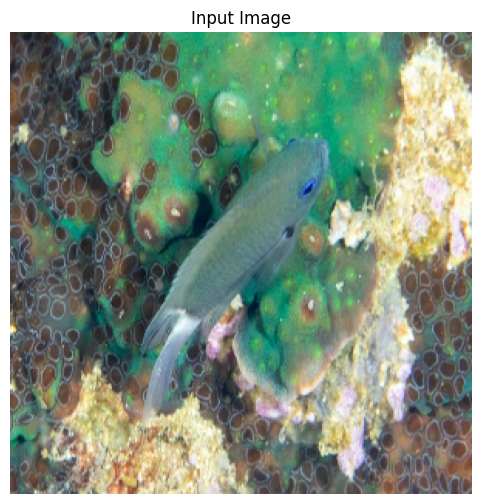

Top 3 Family Predictions:
Blenniidae: 0.7779
Pomacentridae: 0.0919
Gobiidae: 0.0556
Pseudochromidae: 0.0526
Labridae: 0.0088

Top 3 Genus Predictions:
Ecsenius: 0.2543
Cirripectes: 0.0917
Chromis: 0.0849
Pomacentrus: 0.0684
Cypho: 0.0629

Top 3 Species Predictions:
Cirripectes_variolosus: 0.1493
Ecsenius_pulcher: 0.1050
Enchelyurus_ater: 0.1025
Ecsenius_stictus: 0.0661
Priolepis_semidoliatus: 0.0526
image_path      /Users/leonardo/Documents/Projects/cryptovisio...
folder_label                   Pomacentridae_Chromis_margaritifer
family                                              Pomacentridae
genus                                                     Chromis
species                                      Chromis margaritifer
Name: 3587, dtype: object


In [46]:
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset/Gobiidae_Eviota_melasma/web_Eviota_melasma_41.jpeg'

idx = 2

image_path = test_df['image_path'].iloc[idx]


top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, family_labels, genus_labels, species_labels, top_k=5, image_size=settings['img_size']
)

print(test_df.iloc[idx])


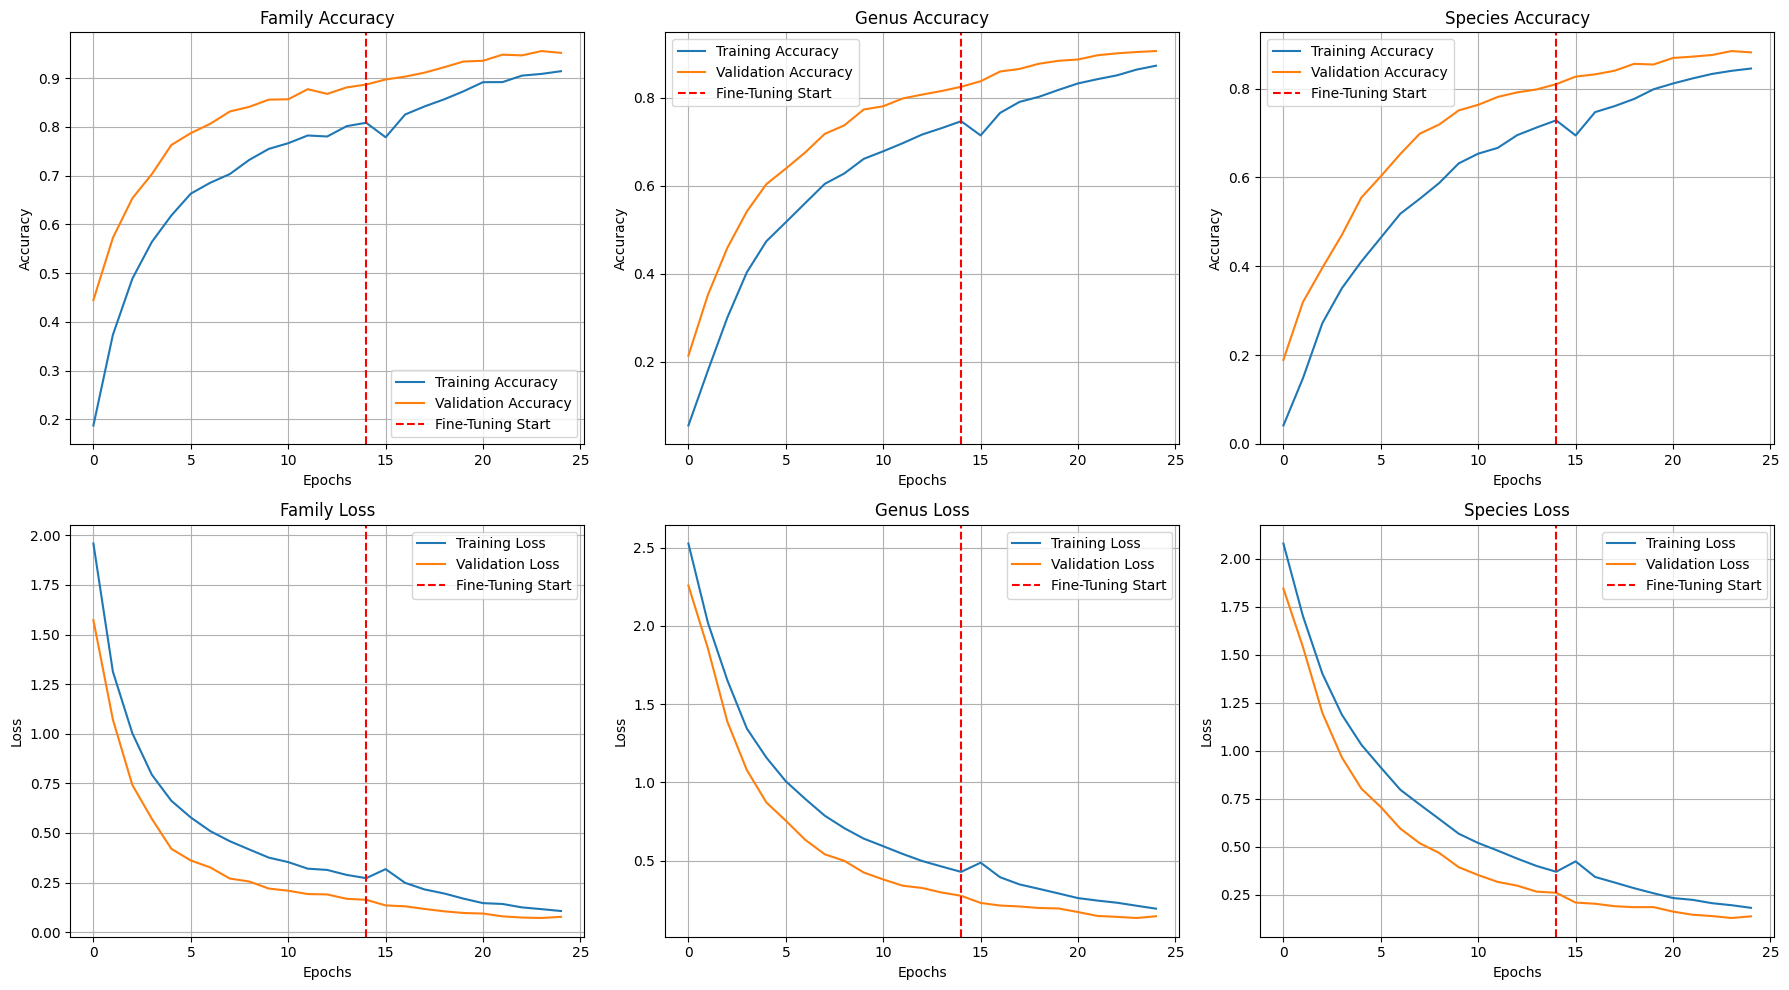

In [16]:
plot_training_history(history, history_fine, fine_tune_at=settings['epochs']-1)

In [17]:
import os
import numpy as np
from collections import defaultdict
import pandas as pd
import tensorflow as tf

def get_taxonomic_mappings_from_folders(data_dir):
    """
    Extract family, genus, and species mappings from the dataset folder structure.
    
    Args:
    - data_dir (str): Path to the training dataset directory.
    
    Returns:
    - family_labels (list): List of unique family names.
    - genus_labels (list): List of unique genus names.
    - species_labels (list): List of unique species names.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    """
    family_labels = set()
    genus_labels = set()
    species_labels = set()
    genus_to_family = {}
    species_to_genus = {}

    # Iterate through the folders in the data directory
    for folder_name in os.listdir(data_dir):
        # Assume folder names are in the format "family_genus_species"
        parts = folder_name.split('_')
        if len(parts) == 3:
            family, genus, species = parts
            family_labels.add(family)
            genus_labels.add(genus)
            species_full = f"{genus}_{species}"
            species_labels.add(species_full)

            # Map genus to family
            genus_to_family[genus] = family

            # Map species to genus
            species_to_genus[species_full] = genus

    # Sort the labels to maintain consistent ordering
    family_labels = sorted(list(family_labels))
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    return family_labels, genus_labels, species_labels, genus_to_family, species_to_genus

def analyze_taxonomic_misclassifications(model, dataset, family_labels, genus_labels, species_labels, genus_to_family, species_to_genus):
    """
    Analyze misclassifications of a trained model to check if taxonomic hierarchies are respected.
    
    Args:
    - model (tf.keras.Model): The trained model.
    - dataset (tf.data.Dataset): Validation or test dataset.
    - family_labels, genus_labels, species_labels (list): List of class labels for family, genus, and species.
    - genus_to_family (dict): Mapping of genus to family.
    - species_to_genus (dict): Mapping of species to genus.
    
    Returns:
    - summary (dict): A dictionary containing summary of misclassifications.
    - genus_df (DataFrame): DataFrame with genus misclassification details.
    - species_df (DataFrame): DataFrame with species misclassification details.
    """
    # Counters for misclassifications
    genus_misclassifications = defaultdict(int)
    genus_respect_family = 0
    genus_total_mistakes = 0

    species_misclassifications = defaultdict(int)
    species_respect_genus = 0
    species_respect_family = 0
    species_total_mistakes = 0

    # Iterate over the dataset to collect predictions and true labels
    for images, labels in dataset:
        # Get the logits from the model for each output (family, genus, species)
        family_logits, genus_logits, species_logits = model(images, training=False)

        # Get true and predicted labels for each level
        true_family_indices = tf.argmax(labels['family'], axis=1).numpy()
        true_genus_indices = tf.argmax(labels['genus'], axis=1).numpy()
        true_species_indices = tf.argmax(labels['species'], axis=1).numpy()

        pred_family_indices = np.argmax(family_logits, axis=1)
        pred_genus_indices = np.argmax(genus_logits, axis=1)
        pred_species_indices = np.argmax(species_logits, axis=1)

        # Analyze genus misclassifications
        for true_genus_idx, pred_genus_idx in zip(true_genus_indices, pred_genus_indices):
            if true_genus_idx != pred_genus_idx:
                genus_total_mistakes += 1
                true_genus = genus_labels[true_genus_idx]
                pred_genus = genus_labels[pred_genus_idx]

                # Count the misclassification
                genus_misclassifications[(true_genus, pred_genus)] += 1

                # Check if the misclassified genus is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)  # Use .get() in case pred_genus is missing
                if true_family == pred_family:
                    genus_respect_family += 1

        # Analyze species misclassifications
        for true_species_idx, pred_species_idx in zip(true_species_indices, pred_species_indices):
            if true_species_idx != pred_species_idx:
                species_total_mistakes += 1
                true_species = species_labels[true_species_idx]
                pred_species = species_labels[pred_species_idx]

                # Count the misclassification
                species_misclassifications[(true_species, pred_species)] += 1

                # Check if the misclassified species is in the same genus
                true_genus = species_to_genus[true_species]
                pred_genus = species_to_genus.get(pred_species, None)
                if true_genus == pred_genus:
                    species_respect_genus += 1

                # Check if the misclassified species is in the same family
                true_family = genus_to_family[true_genus]
                pred_family = genus_to_family.get(pred_genus, None)
                if true_family == pred_family:
                    species_respect_family += 1

    # Calculate percentages of misclassifications that respect the hierarchy
    genus_hierarchy_respect_pct = (genus_respect_family / genus_total_mistakes) * 100 if genus_total_mistakes > 0 else 0
    species_hierarchy_respect_genus_pct = (species_respect_genus / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0
    species_hierarchy_respect_family_pct = (species_respect_family / species_total_mistakes) * 100 if species_total_mistakes > 0 else 0

    # Create a summary of the analysis
    summary = {
        'genus_total_mistakes': genus_total_mistakes,
        'genus_hierarchy_respect': genus_respect_family,
        'genus_hierarchy_respect_pct': genus_hierarchy_respect_pct,
        'genus_misclassifications': dict(genus_misclassifications),
        'species_total_mistakes': species_total_mistakes,
        'species_hierarchy_respect_genus': species_respect_genus,
        'species_hierarchy_respect_genus_pct': species_hierarchy_respect_genus_pct,
        'species_hierarchy_respect_family': species_respect_family,
        'species_hierarchy_respect_family_pct': species_hierarchy_respect_family_pct,
        'species_misclassifications': dict(species_misclassifications),
    }

    # Convert misclassification dictionaries to DataFrames for better readability
    genus_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in genus_misclassifications.items()],
        columns=['True Genus', 'Predicted Genus', 'Count']
    ).sort_values(by='Count', ascending=False)

    species_df = pd.DataFrame(
        [(true, pred, count) for (true, pred), count in species_misclassifications.items()],
        columns=['True Species', 'Predicted Species', 'Count']
    ).sort_values(by='Count', ascending=False)

    # Print the summaries
    print(f"Genus Misclassifications: {genus_total_mistakes}")
    print(f"Genus Misclassifications Respecting Family: {genus_respect_family} ({genus_hierarchy_respect_pct:.2f}%)")
    print(f"\nTop Genus Misclassifications:\n{genus_df.head(10)}")

    print(f"\nSpecies Misclassifications: {species_total_mistakes}")
    print(f"Species Misclassifications Respecting Genus: {species_respect_genus} ({species_hierarchy_respect_genus_pct:.2f}%)")
    print(f"Species Misclassifications Respecting Family: {species_respect_family} ({species_hierarchy_respect_family_pct:.2f}%)")
    print(f"\nTop Species Misclassifications:\n{species_df.head(10)}")

    return summary, genus_df, species_df

# Example usage:
# Assuming 'train_dir' is the path to the training dataset directory.
train_dir = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"
family_labels, genus_labels, species_labels, genus_to_family, species_to_genus = get_taxonomic_mappings_from_folders(train_dir)

# Now analyze the misclassifications using the mappings
summary, genus_df, species_df = analyze_taxonomic_misclassifications(
    model=model,
    dataset=test_ds,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
    genus_to_family=genus_to_family,
    species_to_genus=species_to_genus
)

Genus Misclassifications: 143
Genus Misclassifications Respecting Family: 56 (39.16%)

Top Genus Misclassifications:
        True Genus Predicted Genus  Count
57      Istigobius      Fusigobius      6
0      Enneanectes  Enneapterygius      5
4           Eviota            Ucla      4
62            Ucla  Enneapterygius      4
1    Sebastapistes    Scorpaenodes      4
12        Ecsenius     Cirripectes      4
22      Fusigobius      Istigobius      4
47  Corythoichthys      Istigobius      3
31       Priolepis          Eviota      3
17          Apogon    Pristiapogon      2

Species Misclassifications: 162
Species Misclassifications Respecting Genus: 24 (14.81%)
Species Misclassifications Respecting Family: 79 (48.77%)

Top Species Misclassifications:
                   True Species             Predicted Species  Count
38         Fusigobius_neophytus          Istigobius_decoratus      8
63         Istigobius_decoratus          Fusigobius_neophytus      6
0       Enneapterygius_tutuilae  

2024-10-30 15:56:49.196518: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
model.save("/Users/leonardo/Documents/Projects/cryptovision/models/hacpl_rn50v2_proteon_classifier.keras")

/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         'family': lambda y_true, y_pred: combined_hierarchical_loss(y_true, y_pred, y_true, y_pred, y_true, y_pred),

  return {key: serialize_keras_object(value) for key, value in obj.items()}
/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serial